### Convolutional Neural Network (CNN) with Tensorflow

# Identyfy objects in CIFAR10 dataset. 

The CIFAR-10 dataset (Canadian Institute For Advanced Research) is a collection of images that are commonly used to train machine learning and computer vision algorithms. The CIFAR-10 dataset contains 60,000 32x32 color images in 10 different classes. There are 6,000 images of each class.

The 10 different classes are- 

Airplane, Automobile, Bird, Cat, Deer, Dog, Frog, Horse, Ship, Truck


In [1]:
# Make it work with python2 as well
from __future__ import print_function, division
from builtins import range

# Needed imports
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf

In [2]:
cifar10 = tf.keras.datasets.cifar10

(XtrainOrig, YtrainOrig),(XtestOrig, YtestOrig) = cifar10.load_data()
catagMap = ["Airplane", "Automobile", "Bird", "Cat", "Deer", "Dog", "Frog", "Horse", "Ship", "Truck"]

### Display Samples from dataset

Image catagory for displayed images:
Frog	Automobile	Deer	Truck	Deer	
Truck	Bird	Horse	Truck	Cat	
Truck	Horse	Horse	Cat	Frog	


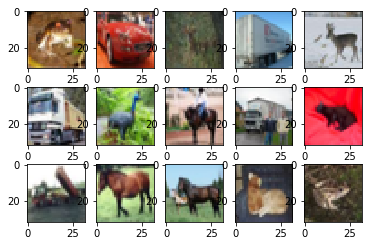

XtrainOrig.shape = (50000, 32, 32, 3) 		YtrainOrig.shape = (50000, 1)
XtestOrig.shape = (10000, 32, 32, 3) 		YtestOrig.shape = (10000, 1)


In [3]:
f, axarr = plt.subplots(3, 5)
print("Image catagory for displayed images:")
for i in range(3):
    for j in range(5):
        index = i + 5*j
        print(catagMap[YtrainOrig[index][0]], end='\t')
        axarr[i, j].imshow(XtrainOrig[index], cmap='gray')
    print()
plt.show()

print("XtrainOrig.shape =", XtrainOrig.shape, "\t\tYtrainOrig.shape =", YtrainOrig.shape)
print("XtestOrig.shape =", XtestOrig.shape, "\t\tYtestOrig.shape =", YtestOrig.shape)


### Prepare dataset for learning

Reshape the vector to add dimention for color channel. Here we have only one color channel. 
Then convert the pixel values in range 0 to 1 (float).

In [4]:
# Divide by 255.0
Xtrain, Xtest = XtrainOrig.astype(np.float32) / 255.0, XtestOrig.astype(np.float32) / 255.0
# somehow Y arrays are 2D arrays, flatten those to 1D vectors
Ytrain, Ytest = YtrainOrig.reshape(YtrainOrig.shape[0]), YtestOrig.reshape(YtestOrig.shape[0])

# Convert columar indicator vector to binary indicator matrix.
# Ex. Y = [2, 1, 0]
# return T = [[0, 0, 1], [0, 1, 0], [1, 0, 0]]
def conv_indicator_to_matrix(Y, numClasses):
    N = len(Y)
    T = np.zeros((N, numClasses))
    for i in range(N):
        T[i, int(Y[i])] = 1
    return T

# Number of Catagories
numCatag = 10

Ytrain_ind = conv_indicator_to_matrix(YtrainOrig, numCatag).astype(np.float32)
Ytest_ind = conv_indicator_to_matrix(YtestOrig, numCatag).astype(np.float32)

print("Number of samples in each catagories in training-set\n", Ytrain_ind.sum(axis=0).astype(np.int32))
print("Number of samples in each catagories in testing-set\n", Ytest_ind.sum(axis=0).astype(np.int32))
print("")

print("Xtrain.shape =", Xtrain.shape, "\tYtrain.shape =", Ytrain.shape, "\tYtrain_ind.shape =", Ytrain_ind.shape)
print("Xtest.shape =", Xtest.shape, "\tYtest.shape =", Ytest.shape, "\tYtest_ind.shape =", Ytest_ind.shape)

print("Xtrain.dtype =", Xtrain.dtype, "\t\tYtrain_ind.dtype =", Ytrain_ind.dtype)
print("Xtest.dtype =", Xtest.dtype, "\t\tYtest_ind.dtype =", Ytest_ind.dtype)

debugP = 0
def dprint(*args, **kwargs):
    sepp = " "
    if kwargs is not None:
        if "sep" in kwargs:
            sepp = kwargs["sep"]
    if debugP:
        print(sepp.join(map(str,args)), **kwargs)


Number of samples in each catagories in training-set
 [5000 5000 5000 5000 5000 5000 5000 5000 5000 5000]
Number of samples in each catagories in testing-set
 [1000 1000 1000 1000 1000 1000 1000 1000 1000 1000]

Xtrain.shape = (50000, 32, 32, 3) 	Ytrain.shape = (50000,) 	Ytrain_ind.shape = (50000, 10)
Xtest.shape = (10000, 32, 32, 3) 	Ytest.shape = (10000,) 	Ytest_ind.shape = (10000, 10)
Xtrain.dtype = float32 		Ytrain_ind.dtype = float32
Xtest.dtype = float32 		Ytest_ind.dtype = float32


### Defining the Convolutional Neural Network (CNN) with two convolutional layers

In [5]:
# H - Hight of image, W - Width of image, C - number of color channels
# Ntr - Number of samples in traing set
# Ntt - Number of samples in test set
Ntr, H, W, C = Xtrain.shape
Ntt = Xtest.shape[0]
# Pool size for max pooling
poolsz = (2, 2)

M = 500 # Number of nodes in fully connected layer
# Number of nodes in output layer, this is equal to number of catagories in the data
K = numCatag


def initFilter(shape, poolsz):
    w = np.random.randn(*shape) * np.sqrt(2.0 / np.prod(shape[:-1]))
    # w = np.random.randn(*shape) * np.sqrt(2) / np.sqrt(np.prod(shape[:-1]) 
    #     + shape[-1]*np.prod(shape[:-2]) / np.prod(poolsz))
    return w.astype(np.float32)

C1_FilterWidth, C1_FilterHight = 3, 3
C1_NumFeatureMaps = 50
C1_OutWidth = W // poolsz[0]  # Devide for pooling
C1_OutHight = H // poolsz[1]  # Devide for pooling
#C1_OutWidth = (H - (C1_FilterWidth -1)) / poolsz[0]  # Devide for pooling
#C1_OutHight = (H - (C1_FilterHight -1)) / poolsz[1]  # Devide for pooling

C2_FilterWidth, C2_FilterHight = 3, 3
C2_NumFeatureMaps = 100
C2_OutWidth = C1_OutWidth // poolsz[0]  # Devide for pooling
C2_OutHight = C1_OutHight // poolsz[1]  # Devide for pooling
#C2_OutWidth = (C1_OutWidth - (C2_FilterWidth -1)) / poolsz[0]  # Devide for pooling
#C2_OutHight = (C1_OutHight - (C2_FilterHight -1)) / poolsz[1]  # Devide for pooling

# Initial weights and bias for convolutional layers
W1_shape = (C1_FilterWidth, C1_FilterHight, C, C1_NumFeatureMaps)
W1_init = initFilter(W1_shape, poolsz)
b1_init = np.zeros(W1_shape[-1], dtype=np.float32) # one bias per output feature map

W2_shape = (C2_FilterWidth, C2_FilterHight, C1_NumFeatureMaps, C2_NumFeatureMaps)
W2_init = initFilter(W2_shape, poolsz)
b2_init = np.zeros(W2_shape[-1], dtype=np.float32)

# Initial weights and bias for fully connected layer
W3_inSize = C2_NumFeatureMaps * C2_OutWidth * C2_OutHight
W3_init = np.random.randn(W3_inSize, M) / np.sqrt(W3_inSize + M)
b3_init = np.zeros(M, dtype=np.float32)
W4_init = np.random.randn(M, K) / np.sqrt(M + K)
b4_init = np.zeros(K, dtype=np.float32)


# Define placeholders for inputs.
tfX = tf.placeholder(tf.float32, shape=(None, H, W, C), name='X')
tfY = tf.placeholder(tf.float32, shape=(None, K), name='Y')

# Variable for neural network weights. These are updated by Tensorflow during training.
# These weights are learned during training.
W1 = tf.Variable(W1_init.astype(np.float32), name="W1")
b1 = tf.Variable(b1_init.astype(np.float32), name="b1")
W2 = tf.Variable(W2_init.astype(np.float32), name="W2")
b2 = tf.Variable(b2_init.astype(np.float32), name="b2")
W3 = tf.Variable(W3_init.astype(np.float32), name="W3")
b3 = tf.Variable(b3_init.astype(np.float32), name="b3")
W4 = tf.Variable(W4_init.astype(np.float32), name="W4")
b4 = tf.Variable(b4_init.astype(np.float32), name="b4")

def convpool(X, W, b, psz):
    # just assume pool size is (2,2) because we need to augment it with 1s
    conv_out = tf.nn.conv2d(X, W, strides=[1, 1, 1, 1], padding='SAME')
    conv_out = tf.nn.bias_add(conv_out, b)
    pool_out = tf.nn.max_pool(conv_out, ksize=[1, psz[0], psz[1], 1], strides=[1, psz[0], psz[1], 1], padding='SAME')
    return tf.nn.relu(pool_out)

Z1 = convpool(tfX, W1, b1, poolsz)
Z2 = convpool(Z1, W2, b2, poolsz)
Z2_shape = Z2.get_shape().as_list()
Z2r = tf.reshape(Z2, shape=[-1, np.prod(Z2_shape[1:])])
Z3 = tf.nn.relu( tf.matmul(Z2r, W3) + b3 )
Y_bar = tf.matmul(Z3, W4) + b4 # In Tensorflow, the cost function includes the softmax, so not needed here.



lr = 0.001
reg = 0.01

# define the cost function and prediction
# softmax_cross_entropy_with_logits take in the "logits"
# if we wanted to know the actual output of the neural net,
# we can pass "Y_bar" into tf.nn.softmax(logits)
cost_fn = tf.reduce_sum(tf.nn.softmax_cross_entropy_with_logits_v2(logits=Y_bar, labels=tfY))
# cost = tf.reduce_sum(tf.nn.sparse_softmax_cross_entropy_with_logits(logits=Y_bar,labels=tfY))

# we don't implement the learning algorithm ourselves.
# We use the RMSprop optimizer provided by Tensorflow. It includes momentum as well.
train_op = tf.train.RMSPropOptimizer(lr, decay=(1-reg), momentum=0.9).minimize(cost_fn)

# We'll use this to calculate the error rate
predict_op = tf.argmax(Y_bar, 1)


### Training the neural network with Stochastic Gradient Descent using mini batches


In [6]:
def error_rate(p, t):
    return np.mean(p != t)

def comp_cost(sess, c_fn, tfX, tfY, xx, yy_ind, bat_sz):
    nn = xx.shape[0]
    n_bats = nn // bat_sz
    cost = 0.
    dprint("comp_cost iterations")
    for ii in range(n_bats):
        dprint(ii, end=' ')
        Xbat = xx[ii*bat_sz:(ii*bat_sz + bat_sz),]
        Ybat_ind = yy_ind[ii*bat_sz:(ii*bat_sz + bat_sz),]
        cost += sess.run(c_fn, feed_dict={tfX: Xbat, tfY: Ybat_ind})
    dprint("")
    return cost

def predict(sess, p_fn, tfX, xx, bat_sz):
    nn = xx.shape[0]
    n_bats = nn // bat_sz
    pred_l = []
    dprint("predict iterations")
    for ii in range(n_bats):
        dprint(ii, end=' ')
        Xbat = xx[ii*bat_sz:(ii*bat_sz + bat_sz),]
        pred_l.append(session.run(p_fn, feed_dict={tfX: Xbat}))
    dprint("")
    return np.concatenate(pred_l)

max_iter = 20
log_period = 25
batch_sz = 1000
n_batches = Ntr // batch_sz

#t0 = datetime.now()

tr_costs = []
tt_costs = []
W1_val = None
W2_val = None

init = tf.global_variables_initializer()
with tf.Session() as session:
    session.run(init)
    
    for epoch in range(max_iter):
        first = 1
        for j in range(n_batches):
            dprint("Inner loop index =\t", epoch, "\t" , j)
            Xbatch = Xtrain[j*batch_sz:(j*batch_sz + batch_sz),]
            Ybatch = Ytrain_ind[j*batch_sz:(j*batch_sz + batch_sz),]

            session.run(train_op, feed_dict={tfX: Xbatch, tfY: Ybatch})

            # Compute cost on test set to see the learning progress
            if j % log_period == 0:
                tr_cost, tt_cost = 0, 0
                #tr_cost = session.run(cost_fn, feed_dict={tfX: Xtrain, tfY: Ytrain_ind})
                tr_cost = comp_cost(session, cost_fn, tfX, tfY, Xtrain, Ytrain_ind, 1000)
                tt_cost = comp_cost(session, cost_fn, tfX, tfY, Xtest, Ytest_ind, 1000)
                #costs.append([tr_cost, tt_cost])
                tr_costs.append(tr_cost)
                tt_costs.append(tt_cost)
                if first:
                    first = 0
                    tr_pred, tr_err = 0, 0
                    # Disabled to save runtime
                    #tr_pred = predict(session, predict_op, tfX, Xtrain, 1000)
                    #tr_err = error_rate(tr_pred, Ytrain)
                    tt_pred, tt_err = 0, 0
                    tt_pred = predict(session, predict_op, tfX, Xtest, 1000)
                    tt_err = error_rate(tt_pred, Ytest)
                    print("Cost / err at epoch %d:\ttrain(%.1f / %.3f)\ttest(%.1f / %.3f / %.3f)"
                          % (epoch, tr_cost, tr_err, tt_cost, tt_err, tt_err2))
    
    W1_val = W1.eval()
    W2_val = W2.eval()
    
    tt_pred = predict(session, predict_op, tfX, Xtest, 1000)
    tt_err = error_rate(tt_pred, Ytest)
    print("Prediction error with test set =\t", tt_err)
    tr_pred = predict(session, predict_op, tfX, Xtrain, 1000)
    tr_err = error_rate(tr_pred, Ytrain)
    print("Prediction error with training set =\t", tr_err)



Cost / err at epoch 0:	train(806930.9 / 0.000)	test(161976.6 / 0.850)
Cost / err at epoch 1:	train(93537.5 / 0.000)	test(18744.6 / 0.677)
Cost / err at epoch 2:	train(86697.3 / 0.000)	test(17395.5 / 0.630)
Cost / err at epoch 3:	train(85143.0 / 0.000)	test(17102.7 / 0.631)
Cost / err at epoch 4:	train(73705.3 / 0.000)	test(14958.9 / 0.544)
Cost / err at epoch 5:	train(70840.7 / 0.000)	test(14515.7 / 0.521)
Cost / err at epoch 7:	train(63355.7 / 0.000)	test(13291.6 / 0.471)
Cost / err at epoch 8:	train(60353.0 / 0.000)	test(13000.8 / 0.465)
Cost / err at epoch 9:	train(56253.9 / 0.000)	test(12429.4 / 0.442)
Cost / err at epoch 10:	train(55820.2 / 0.000)	test(12498.2 / 0.439)
Cost / err at epoch 11:	train(53891.3 / 0.000)	test(12397.4 / 0.434)
Cost / err at epoch 12:	train(54713.2 / 0.000)	test(12651.4 / 0.438)
Cost / err at epoch 13:	train(53348.9 / 0.000)	test(12557.8 / 0.433)
Cost / err at epoch 14:	train(50088.6 / 0.000)	test(12171.2 / 0.419)
Cost / err at epoch 15:	train(50551.1 / 0

### Plot the learning

How cost function is improving with iterations

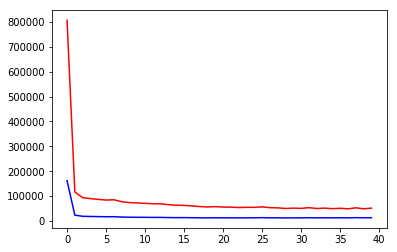

In [7]:
plt.plot(tr_costs, 'r')
plt.plot(tt_costs, 'b')
plt.show()


### Visualize the convolution filters

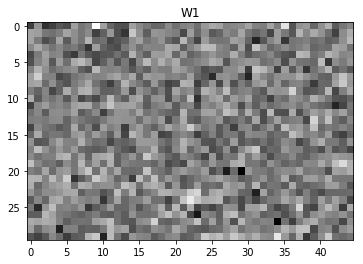

In [8]:
W1_val = W1_val.transpose(3, 2, 0, 1)
# visualize W1 (C1_NumFeatureMaps, C, C1_FilterWidth, C1_FilterHight)
# W1_val = W1.get_value()
grid = np.zeros((10*C1_FilterWidth, 15*C1_FilterHight))
m = 0
n = 0
for i in range(C1_NumFeatureMaps):
    for j in range(C):
        filt = W1_val[i,j]
        grid[m*C1_FilterWidth:(m+1)*C1_FilterWidth, n*C1_FilterHight:(n+1)*C1_FilterHight] = filt
        m += 1
        if m >= 10:
            m = 0
            n += 1
plt.imshow(grid, cmap='gray')
plt.title("W1")
plt.show()



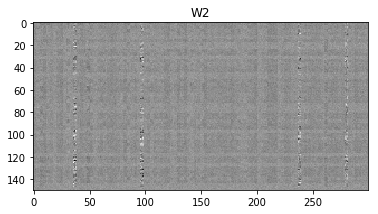

In [9]:
W2_val = W2_val.transpose(3, 2, 0, 1)
# visualize W2 (C2_NumFeatureMaps, C1_NumFeatureMaps, C2_FilterWidth, C2_FilterHight)
# W2_val = W2.get_value()
grid = np.zeros((50*C2_FilterWidth, 100*C2_FilterHight))
m = 0
n = 0
for i in range(C2_NumFeatureMaps):
    for j in range(C1_NumFeatureMaps):
        filt = W2_val[i,j]
        grid[m*C2_FilterWidth:(m+1)*C2_FilterWidth, n*C2_FilterHight:(n+1)*C2_FilterHight] = filt
        m += 1
        if m >= 50:
            m = 0
            n += 1
plt.imshow(grid, cmap='gray')
plt.title("W2")
plt.show()
